In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns

from src.config import Config
from src.scripts.conlleval import count_chunks, evaluate
from src.model.cnn_lstm_crf_model import CharCNNLSTMCRFModel

## Trained model

In [3]:
# load pretrained model
model = CharCNNLSTMCRFModel()
model.build()
model.restore_session(Config.dir_model)

/home/canh/NLP/NER/ner_cnn_lstm_crf/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Initializing tf session
Loading the trained model from outputs/train/model.weights/


INFO:tensorflow:Restoring parameters from outputs/train/model.weights/


Restoring parameters from outputs/train/model.weights/


In [11]:
model.predict("France president Emmanuel Macron is in US trip".split())

['B-LOC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'B-LOC', 'O']

## Test dataset

In [12]:
df = pd.read_csv('./results/test.preds.txt', sep=' ', header=None,  quoting = 3, names=['word', 'label', 'pred'])
df.head(10)

,word,label,pred
0,SOCCER,O,O
1,-,O,O
2,JAPAN,B-LOC,B-LOC
3,GET,O,O
4,LUCKY,O,B-PER
5,WIN,O,O
6,",",O,O
7,CHINA,B-PER,B-LOC
8,IN,O,O
9,SURPRISE,O,O


In [6]:
evaluate(pred_seqs=df.pred, true_seqs=df.label, verbose=True)

processed 46435 tokens with 5648 phrases; found: 5707 phrases; correct: 5098.
accuracy:  91.57%; (non-O)
accuracy:  97.76%; precision:  89.33%; recall:  90.26%; FB1:  89.79
              LOC: precision:  90.72%; recall:  93.23%; FB1:  91.96  1714
             MISC: precision:  76.54%; recall:  79.49%; FB1:  77.99  729
              ORG: precision:  87.11%; recall:  87.06%; FB1:  87.08  1660
              PER: precision:  95.95%; recall:  95.18%; FB1:  95.56  1604


(89.32889434028385, 90.26203966005666, 89.79304271246149)

In [7]:
def get_wrong_sentences(df):
    sents = []

    current_sent = []
    is_correct = True
    
    for index, row in df.iterrows():
        current_sent.append({'word':row['word'], 'label': row['label'], 'pred':row['pred']})
        is_correct = is_correct and (row['pred'] == row['label'])
            
        if row['word'] == ".":            
            if not is_correct:
                sents.extend(current_sent)
                
            current_sent = []
            is_correct = True
                
    return pd.DataFrame(sents)

In [8]:
df_wrong = get_wrong_sentences(df)
df_wrong

## Transision matrix

In [14]:
model.features_generator.tag_to_idx

{'B-LOC': 0,
 'I-ORG': 1,
 'I-LOC': 2,
 'O': 3,
 'B-MISC': 4,
 'I-PER': 5,
 'B-ORG': 6,
 'B-PER': 7,
 'I-MISC': 8}

In [51]:
tags = [key for key, value in sorted(model.features_generator.tag_to_idx.items(), key =lambda v: (v[1],v[0]))]
tags

['B-LOC', 'I-ORG', 'I-LOC', 'O', 'B-MISC', 'I-PER', 'B-ORG', 'B-PER', 'I-MISC']

In [52]:
trans_params = model.sess.run(model.trans_params)
df_A = pd.DataFrame(trans_params)
df_A.columns = tags
df_A.index = tags
df_a

,B-LOC,I-ORG,I-LOC,O,B-MISC,I-PER,B-ORG,B-PER,I-MISC
B-LOC,-1.618199,-4.763782,1.444532,-0.267319,-0.013306,-4.025904,-0.207025,-0.944706,-3.881173
I-ORG,-2.305755,1.098130,-3.223040,-0.547589,-0.643323,-2.901667,-2.790273,-0.900746,-4.106915
I-LOC,-0.964437,-2.609053,1.049729,0.050310,0.277616,-1.143677,-0.272134,-1.352896,-1.760038
O,0.548766,-5.330478,-3.410762,0.463098,0.164864,-3.269908,0.356064,0.814850,-4.271561
B-MISC,-0.033138,-4.062712,-3.318513,0.050983,-1.426718,-3.170748,0.374306,-0.240002,1.790405
I-PER,-1.281667,-2.139382,-1.178923,0.094655,-1.010966,0.356903,-0.907899,-1.689131,-2.056577
B-ORG,-1.043540,2.109104,-4.882005,-0.504722,-0.886986,-3.914043,-2.482193,-1.374141,-4.260591
B-PER,-0.384951,-3.902620,-3.828512,0.184943,-1.080988,1.798162,-1.638041,-3.434614,-2.779956
I-MISC,-0.968646,-2.814469,-1.766761,-0.276108,-0.394021,-2.243167,0.004656,-0.546013,0.932588


locator: <matplotlib.ticker.MaxNLocator object at 0x7f895705fbe0>
Using auto colorbar locator on colorbar
locator: <matplotlib.ticker.MaxNLocator object at 0x7f895705fbe0>
Setting pcolormesh
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


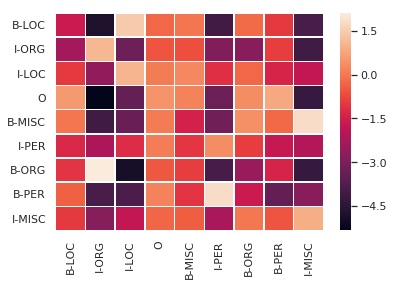

In [59]:
ax = sns.heatmap(df_A, linewidths=.5)

In [ ]:
sort_columns = ['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC', 'B-PER', 'I-PER']
sort_index = ['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC', 'B-PER', 'I-PER']